# Capstone Project - The Battle of Neighbourhoods in London

In [1]:
#Intended blank cell to install dependency
!pip install folium

     |████████████████████████████████| 93 kB 2.9 MB/s eta 0:00:011


In [2]:
import numpy as np

import pandas as pd

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import json # library to handle JSON files

import requests # library to handle requests

from pandas import json_normalize # tranform JSON file into a pandas dataframe

import seaborn as sns

from matplotlib import pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Section 1 - Obtain raw data

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/London_boroughs#Former_authorities')[2]
df

,London borough,Designation,Former areas,Former areas.1,Former areas.2,Former areas.3,Former areas.4
0,Camden,Inner,Hampstead (11a),St Pancras (11b),Holborn (11c),NaN,NaN
1,Greenwich,Inner,Greenwich (22a),Woolwich (part) (22b),NaN,NaN,NaN
2,Hackney,Inner,Hackney (9a),Shoreditch (9b),Stoke Newington (9c),NaN,NaN
3,Hammersmith[notes 2],Inner,Hammersmith (4a),Fulham (4b),NaN,NaN,NaN
4,Islington,Inner,Islington (10a),Finsbury (10b),NaN,NaN,NaN
5,Kensington and Chelsea,Inner,Kensington (3a),Chelsea (3b),NaN,NaN,NaN
6,Lambeth,Inner,Lambeth (6a),Wandsworth (part) (6b),NaN,NaN,NaN
7,Lewisham,Inner,Lewisham (21a),Deptford (21b),NaN,NaN,NaN
8,Southwark,Inner,Bermondsey (7b),Camberwell (7c),Southwark (7a),NaN,NaN
9,Tower Hamlets,Inner,Bethnal Green (8a),Poplar (8c),Stepney (8b),NaN,NaN


<h5>Remove columns and filter non-central london location</h5>

In [4]:
df.drop(df.columns[2:7], axis=1, inplace=True)
df.rename(columns={df.columns[0]: "Borough"}, inplace=True)
df['Borough'] = df['Borough'].str.split('[').str[0] + ', London'
df

,Borough,Designation
0,"Camden, London",Inner
1,"Greenwich, London",Inner
2,"Hackney, London",Inner
3,"Hammersmith, London",Inner
4,"Islington, London",Inner
5,"Kensington and Chelsea, London",Inner
6,"Lambeth, London",Inner
7,"Lewisham, London",Inner
8,"Southwark, London",Inner
9,"Tower Hamlets, London",Inner


In [5]:
df.shape

(32, 2)

<h5>Retrieve Geospatial Data</h5>

In [6]:
geolocator = Nominatim(user_agent="London_Analysis")

df['location_details'] = df['Borough'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['location_details'].apply(pd.Series)
df.drop(['location_details'], axis=1, inplace = True)
df['Borough'] = df['Borough'].str.replace(', London', '')

df

,Borough,Designation,Latitude,Longitude
0,Camden,Inner,51.542305,-0.139560
1,Greenwich,Inner,51.482084,-0.004542
2,Hackney,Inner,51.543240,-0.049362
3,Hammersmith,Inner,51.492038,-0.223640
4,Islington,Inner,51.538429,-0.099905
5,Kensington and Chelsea,Inner,51.498480,-0.199043
6,Lambeth,Inner,51.501301,-0.117287
7,Lewisham,Inner,51.462432,-0.010133
8,Southwark,Inner,51.502922,-0.103458
9,Tower Hamlets,Inner,51.134101,1.300349


# Section 2 - Clustering Neighbourhood in London

In [7]:
london = geolocator.geocode("London")
latitude = london.latitude
longitude = london.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [8]:
# create map of Tokyo using latitude and longitude values
london_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, long, label in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london_map) 

london_map

### Retrieve Foursquare Data

In [9]:
CLIENT_ID = 'O3RYYJ2VKACKTAFBLTUXQ4FFUO5M3YB2MHCUKSTUH54QKWGJ' # your Foursquare ID
CLIENT_SECRET = 'HE55ZKECE1BC3AJEKLQXF4DT22AKFADRQJAHR31IQHFS4H03' # your Foursquare Secret
VERSION = '20201101' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Test with one borough

In [10]:
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    df.loc[0, 'Latitude'], 
    df.loc[0, 'Longitude'], 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Regent's Canal,Canal,51.541131,-0.139636
1,Mamasons,Ice Cream Shop,51.543468,-0.141774
2,Crêpes à la carte,French Restaurant,51.544510,-0.141316
3,Pizzeria Di Camden,Pizza Place,51.540920,-0.137667
4,Casa Tua,Italian Restaurant,51.541589,-0.138167


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print ('{} unique categories in Camden'.format(nearby_venues['categories'].value_counts().shape[0]))

87 venues were returned by Foursquare.
50 unique categories in Camden


In [14]:
print (nearby_venues['categories'].value_counts()[0:10])

Pub                     9
Coffee Shop             7
Burger Joint            5
Café                    5
Market                  4
Italian Restaurant      3
Supermarket             2
Beer Bar                2
Clothing Store          2
Caribbean Restaurant    2
Name: categories, dtype: int64


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [16]:
London_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Camden
Greenwich
Hackney
Hammersmith
Islington
Kensington and Chelsea
Lambeth
Lewisham
Southwark
Tower Hamlets
Wandsworth
Westminster
Barking
Barnet
Bexley
Brent
Bromley
Croydon
Ealing
Enfield
Haringey
Harrow
Havering
Hillingdon
Hounslow
Kingston upon Thames
Merton
Newham
Redbridge
Richmond upon Thames
Sutton
Waltham Forest


In [17]:
London_restaurant = London_venues[London_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
London_restaurant = London_restaurant.append(London_venues[London_venues['Venue Category'] == "Pub"].reset_index(drop=True))
London_restaurant.index = np.arange(1, len(London_restaurant )+1)

print (London_restaurant['Venue Category'].value_counts())

Pub                                93
Italian Restaurant                 27
Fast Food Restaurant               20
Indian Restaurant                  19
Restaurant                         13
Portuguese Restaurant              11
Asian Restaurant                   11
Sushi Restaurant                   11
French Restaurant                  10
Thai Restaurant                     9
Japanese Restaurant                 7
Mediterranean Restaurant            7
Turkish Restaurant                  7
Vietnamese Restaurant               7
Chinese Restaurant                  6
Vegetarian / Vegan Restaurant       6
English Restaurant                  6
Ramen Restaurant                    5
Korean Restaurant                   4
Modern European Restaurant          4
Caribbean Restaurant                4
Mexican Restaurant                  4
German Restaurant                   3
Spanish Restaurant                  3
Latin American Restaurant           3
Kebab Restaurant                    3
Greek Restau

In [18]:
print('There are {} uniques restaurant categories.'.format(len(London_restaurant['Venue Category'].unique())))

There are 52 uniques restaurant categories.


In [19]:
# create a dataframe of top 10 categories
London_Rstaurant_10 = London_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
London_Rstaurant_10 = London_Rstaurant_10.reset_index()

London_Rstaurant_10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
London_Rstaurant_10

,Venue_Category,Frequency
0,Pub,93
1,Italian Restaurant,27
2,Fast Food Restaurant,20
3,Indian Restaurant,19
4,Restaurant,13
5,Portuguese Restaurant,11
6,Asian Restaurant,11
7,Sushi Restaurant,11
8,French Restaurant,10
9,Thai Restaurant,9


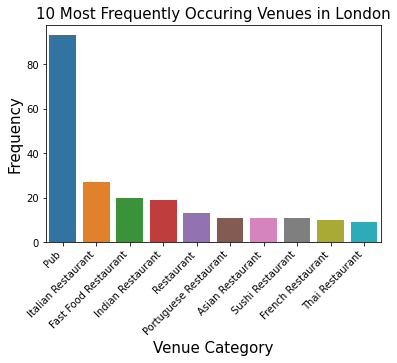

<Figure size 1296x504 with 0 Axes>

In [20]:
s=sns.barplot(x="Venue_Category", y="Frequency", data=London_Rstaurant_10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in London', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
fig = plt.figure(figsize=(18,7))
plt.show()

In [21]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", London_restaurant.shape)
London_restaurant.head(10)

Shape of the Data-Frame with Venue Category only Restaurant:  (338, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Camden,51.542305,-0.13956,Crêpes à la carte,51.544510,-0.141316,French Restaurant
2,Camden,51.542305,-0.13956,Casa Tua,51.541589,-0.138167,Italian Restaurant
3,Camden,51.542305,-0.13956,Domo94 Italian Restaurant,51.541427,-0.138727,Italian Restaurant
4,Camden,51.542305,-0.13956,Lemongrass,51.542472,-0.139018,Asian Restaurant
5,Camden,51.542305,-0.13956,Anima e Cuore,51.544560,-0.141435,Italian Restaurant
6,Camden,51.542305,-0.13956,Mildreds,51.540560,-0.144939,Vegetarian / Vegan Restaurant
7,Camden,51.542305,-0.13956,Guanabana,51.543326,-0.141930,Caribbean Restaurant
8,Camden,51.542305,-0.13956,Woody Grill,51.539459,-0.142021,Middle Eastern Restaurant
9,Camden,51.542305,-0.13956,Ramo Ramen,51.545388,-0.141693,Ramen Restaurant
10,Camden,51.542305,-0.13956,Mamak Don,51.538762,-0.143180,Mamak Restaurant


In [22]:
London_restaurant_by_borough = London_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
London_restaurant_by_borough

Neighborhood
Barking                    3
Barnet                     6
Bexley                     4
Brent                      1
Bromley                    0
Camden                    18
Croydon                    9
Ealing                    24
Enfield                    6
Greenwich                  8
Hackney                    3
Hammersmith               14
Haringey                   3
Harrow                     2
Havering                   8
Hillingdon                 2
Hounslow                  12
Islington                 23
Kensington and Chelsea    11
Kingston upon Thames      27
Lambeth                    9
Lewisham                   7
Merton                     4
Newham                     0
Redbridge                  1
Richmond upon Thames       1
Southwark                 25
Sutton                     1
Tower Hamlets              1
Waltham Forest             0
Wandsworth                 6
Westminster                6
Name: Venue Category, dtype: int64

In [23]:
London_restaurant_by_borough_df  = London_restaurant_by_borough.to_frame().reset_index()
London_restaurant_by_borough_df.columns = ['Neighbourhood', 'Number of Restaurant']
London_restaurant_by_borough_df.index = np.arange(1, len(London_restaurant_by_borough_df)+1)
list_rest_no =London_restaurant_by_borough_df['Number of Restaurant'].to_list()
list_dist =London_restaurant_by_borough_df['Neighbourhood'].to_list()

In [24]:
# one hot encoding
London_onehot = pd.get_dummies(London_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighborhood'] = London_restaurant['Neighborhood'] 

cols = London_onehot.columns.tolist()
cols = cols[-1:] + cols[:-1]

London_onehot = London_onehot[cols]

print(London_onehot.shape)
London_onehot.head()

(338, 53)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,...,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Camden,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Camden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
print(London_grouped.shape)
London_grouped

(32, 53)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,...,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Barking,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Barnet,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bexley,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Brent,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bromley,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Camden,0.00000,0.037037,0.000000,0.000000,0.037037,0.00000,0.000000,0.00000,0.074074,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.074074
6,Croydon,0.00000,0.000000,0.000000,0.000000,0.071429,0.00000,0.000000,0.00000,0.071429,...,0.000000,0.00000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000
7,Ealing,0.00000,0.000000,0.033333,0.000000,0.033333,0.00000,0.000000,0.00000,0.033333,...,0.000000,0.00000,0.033333,0.033333,0.033333,0.000000,0.066667,0.000000,0.000000,0.066667
8,Enfield,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000
9,Greenwich,0.00000,0.000000,0.000000,0.076923,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
num_top_venues = 5

for borough in London_grouped['Neighborhood']:
    print("----"+borough+"----")
    temp = London_grouped[London_grouped['Neighborhood'] == borough].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking----
                   venue  freq
0   Fast Food Restaurant  0.50
1  Portuguese Restaurant  0.25
2                    Pub  0.25
3      Afghan Restaurant  0.00
4       Malay Restaurant  0.00


----Barnet----
                        venue  freq
0                  Restaurant  0.25
1                         Pub  0.25
2        Fast Food Restaurant  0.12
3  Modern European Restaurant  0.12
4          Italian Restaurant  0.12


----Bexley----
                  venue  freq
0                   Pub  0.33
1  Fast Food Restaurant  0.17
2    Italian Restaurant  0.17
3     Indian Restaurant  0.17
4      Greek Restaurant  0.17


----Brent----
                      venue  freq
0         Indian Restaurant   1.0
1         Afghan Restaurant   0.0
2          Malay Restaurant   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----Bromley----
                      venue  freq
0                       Pub   1.0
1         Afghan Restaurant   0.0
2        African Restaurant 

In [27]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbuorhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbuorhoods_venues_sorted['Neighborhood'] = London_grouped['Neighborhood']

for ind in np.arange(London_grouped.shape[0]):
    neighbuorhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighbuorhoods_venues_sorted.head(23)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking,Fast Food Restaurant,Pub,Portuguese Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant
1,Barnet,Pub,Restaurant,Italian Restaurant,Modern European Restaurant,Chinese Restaurant,Fast Food Restaurant,English Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant
2,Bexley,Pub,Italian Restaurant,Indian Restaurant,Greek Restaurant,Fast Food Restaurant,Korean Restaurant,Japanese Restaurant,Israeli Restaurant,German Restaurant,French Restaurant
3,Brent,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Greek Restaurant,German Restaurant,French Restaurant
4,Bromley,Pub,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
5,Camden,Pub,Italian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Asian Restaurant,Korean Restaurant,Malay Restaurant,Mamak Restaurant,Ramen Restaurant
6,Croydon,Pub,Portuguese Restaurant,Asian Restaurant,Indian Restaurant,Malay Restaurant,Mediterranean Restaurant,Caribbean Restaurant,Italian Restaurant,Spanish Restaurant,Sushi Restaurant
7,Ealing,Pub,Italian Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Thai Restaurant,American Restaurant,Portuguese Restaurant,Greek Restaurant,French Restaurant,English Restaurant
8,Enfield,Pub,Turkish Restaurant,Italian Restaurant,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Portuguese Restaurant,Eastern European Restaurant,Israeli Restaurant,Greek Restaurant
9,Greenwich,Pub,Portuguese Restaurant,Italian Restaurant,Mediterranean Restaurant,French Restaurant,English Restaurant,Japanese Restaurant,Argentinian Restaurant,Sushi Restaurant,Austrian Restaurant


# Cluster Neighbourhoods

In [29]:
# set number of clusters
kclusters = 5

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 3, 1, 0, 0, 0, 0, 0], dtype=int32)

In [30]:
# add clustering labels

neighbuorhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_merged = df

London_merged.rename(columns={'Borough':'Neighborhood'}, inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(neighbuorhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

London_merged.head(23) # check the last columns!

,Neighborhood,Designation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Camden,Inner,51.542305,-0.139560,0,Pub,Italian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Asian Restaurant,Korean Restaurant,Malay Restaurant,Mamak Restaurant,Ramen Restaurant
1,Greenwich,Inner,51.482084,-0.004542,0,Pub,Portuguese Restaurant,Italian Restaurant,Mediterranean Restaurant,French Restaurant,English Restaurant,Japanese Restaurant,Argentinian Restaurant,Sushi Restaurant,Austrian Restaurant
2,Hackney,Inner,51.543240,-0.049362,0,Pub,English Restaurant,Modern European Restaurant,Vegetarian / Vegan Restaurant,Argentinian Restaurant,Fast Food Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant
3,Hammersmith,Inner,51.492038,-0.223640,0,Pub,Portuguese Restaurant,Indian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Italian Restaurant,German Restaurant,Asian Restaurant,Sushi Restaurant
4,Islington,Inner,51.538429,-0.099905,0,Pub,Mediterranean Restaurant,French Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Austrian Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant
5,Kensington and Chelsea,Inner,51.498480,-0.199043,0,Italian Restaurant,Pub,Persian Restaurant,Sushi Restaurant,Mediterranean Restaurant,Filipino Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Japanese Restaurant,Falafel Restaurant
6,Lambeth,Inner,51.501301,-0.117287,0,Korean Restaurant,Latin American Restaurant,Restaurant,Japanese Restaurant,Indian Restaurant,French Restaurant,Dim Sum Restaurant,Thai Restaurant,Austrian Restaurant,Brazilian Restaurant
7,Lewisham,Inner,51.462432,-0.010133,0,Fast Food Restaurant,Restaurant,Pub,Portuguese Restaurant,Turkish Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant
8,Southwark,Inner,51.502922,-0.103458,0,Pub,Italian Restaurant,Turkish Restaurant,English Restaurant,Chinese Restaurant,Restaurant,Ramen Restaurant,Vietnamese Restaurant,Kebab Restaurant,Korean Restaurant
9,Tower Hamlets,Inner,51.134101,1.300349,0,Pub,Fast Food Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant


In [31]:
# create map
map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(London_merged['Latitude'], 
                                  London_merged['Longitude'], 
                                  London_merged['Neighborhood'], 
                                  London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

## Examine the Clusters

### Cluster 1

In [32]:
London_merged[London_merged['Cluster Labels'] == 0]

,Neighborhood,Designation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Camden,Inner,51.542305,-0.139560,0,Pub,Italian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Asian Restaurant,Korean Restaurant,Malay Restaurant,Mamak Restaurant,Ramen Restaurant
1,Greenwich,Inner,51.482084,-0.004542,0,Pub,Portuguese Restaurant,Italian Restaurant,Mediterranean Restaurant,French Restaurant,English Restaurant,Japanese Restaurant,Argentinian Restaurant,Sushi Restaurant,Austrian Restaurant
2,Hackney,Inner,51.543240,-0.049362,0,Pub,English Restaurant,Modern European Restaurant,Vegetarian / Vegan Restaurant,Argentinian Restaurant,Fast Food Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant
3,Hammersmith,Inner,51.492038,-0.223640,0,Pub,Portuguese Restaurant,Indian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Italian Restaurant,German Restaurant,Asian Restaurant,Sushi Restaurant
4,Islington,Inner,51.538429,-0.099905,0,Pub,Mediterranean Restaurant,French Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Austrian Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant
5,Kensington and Chelsea,Inner,51.498480,-0.199043,0,Italian Restaurant,Pub,Persian Restaurant,Sushi Restaurant,Mediterranean Restaurant,Filipino Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Japanese Restaurant,Falafel Restaurant
6,Lambeth,Inner,51.501301,-0.117287,0,Korean Restaurant,Latin American Restaurant,Restaurant,Japanese Restaurant,Indian Restaurant,French Restaurant,Dim Sum Restaurant,Thai Restaurant,Austrian Restaurant,Brazilian Restaurant
7,Lewisham,Inner,51.462432,-0.010133,0,Fast Food Restaurant,Restaurant,Pub,Portuguese Restaurant,Turkish Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant
8,Southwark,Inner,51.502922,-0.103458,0,Pub,Italian Restaurant,Turkish Restaurant,English Restaurant,Chinese Restaurant,Restaurant,Ramen Restaurant,Vietnamese Restaurant,Kebab Restaurant,Korean Restaurant
9,Tower Hamlets,Inner,51.134101,1.300349,0,Pub,Fast Food Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant


### Cluster 2

In [33]:
London_merged[London_merged['Cluster Labels'] == 1]

,Neighborhood,Designation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Bromley,Outer,51.366857,0.061709,1,Pub,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
27,Newham,Outer,51.530000,0.029318,1,Pub,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
31,Waltham Forest,Outer,51.598169,-0.017837,1,Pub,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


### Cluster 3

In [34]:
London_merged[London_merged['Cluster Labels'] == 2]

,Neighborhood,Designation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Richmond upon Thames,Outer,51.440553,-0.307639,2,German Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,French Restaurant


### Cluster 4

In [35]:
London_merged[London_merged['Cluster Labels'] == 3]

,Neighborhood,Designation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Brent,Outer,51.563826,-0.275760,3,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Greek Restaurant,German Restaurant,French Restaurant
21,Harrow,Outer,51.596827,-0.337316,3,Afghan Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Greek Restaurant,German Restaurant,French Restaurant


### Cluster 5

In [36]:
London_merged[London_merged['Cluster Labels'] == 4]

,Neighborhood,Designation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Sutton,Outer,51.357464,-0.173627,4,Italian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant
